<a href="https://colab.research.google.com/github/lbuerger/IANNwTF/blob/main/homework9/hw9_210112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import tensorflow as tf
import time

In [11]:
from tensorflow.keras import Model
from tensorflow.keras import layers

class LSTM_Cell(layers.Layer):
  def __init__(self, unit_size):
    super(LSTM_Cell, self).__init__()
    self.forget_layer = layers.Dense(unit_size, activation="sigmoid", bias_initializer="ones")
    self.input_layer = layers.Dense(unit_size, activation="sigmoid")
    self.candidate_layer = layers.Dense(unit_size,  activation="tanh")
    self.output_layer = layers.Dense(unit_size, activation="sigmoid")
  
  def call(self, x, states):
    hidden_state, cell_state = states
    hidden_state = layers.concatenate([x, hidden_state])
    forget_gate = self.forget_layer(hidden_state)
    input_gate = self.input_layer(hidden_state)
    cell_state_candidates = self.candidate_layer(hidden_state)
    cell_state = cell_state * forget_gate + input_gate * cell_state_candidates
    output_gate = self.output_layer(hidden_state)
    hidden_state = output_gate * tf.math.tanh(cell_state)
    return hidden_state, cell_state 
  
class LSTM(layers.Layer):
  def __init__(self, unit_size):
    super(LSTM, self).__init__()
    self.unit_size = unit_size
    self.cell = LSTM_Cell(unit_size)

  def call(self, x):
    sequence_length = x.shape[1]
    outputs = []
    states = self.zero_states(x.shape[0])
    for i in range(sequence_length):
      states = self.cell(x[:,i,:],states)
      outputs.append(states[0])
    return tf.stack(outputs, axis=1)

  def zero_states(self, batch_size):
    state = tf.zeros((batch_size,self.unit_size))
    return (state, state)

class LSTM_Model(Model):
  def __init__(self, unit_size):
    super(LSTM_Model, self).__init__()
    self.unit_size = unit_size
    self.input_layer = layers.Dense(10, activation="sigmoid")
    self.lstm = LSTM(unit_size)
    self.output_layer = layers.Dense(1,activation="sigmoid")

  def call(self, x):
    x = self.input_layer(x)
    x = self.lstm(x)
    x = self.output_layer(x)
    return x

In [12]:
lstm = LSTM_Cell(unit_size=5)
lstm(tf.ones((10,21)),(tf.ones((10,5)),tf.ones([10,5])))

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[0.26082015, 0.3606508 , 0.24511595, 0.15747857, 0.1966048 ],
        [0.26082015, 0.3606508 , 0.24511595, 0.15747857, 0.1966048 ],
        [0.26082015, 0.3606508 , 0.24511595, 0.15747857, 0.1966048 ],
        [0.26082015, 0.3606508 , 0.24511595, 0.15747857, 0.1966048 ],
        [0.26082015, 0.3606508 , 0.24511595, 0.15747857, 0.1966048 ],
        [0.26082015, 0.3606508 , 0.24511595, 0.15747857, 0.1966048 ],
        [0.26082015, 0.3606508 , 0.24511595, 0.15747857, 0.1966048 ],
        [0.26082015, 0.3606508 , 0.24511595, 0.15747857, 0.1966048 ],
        [0.26082015, 0.3606508 , 0.24511595, 0.15747857, 0.1966048 ],
        [0.26082015, 0.3606508 , 0.24511595, 0.15747857, 0.1966048 ]],
       dtype=float32)>, <tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[1.1433828, 0.7421621, 0.8509246, 1.0303158, 0.8188895],
        [1.1433828, 0.7421621, 0.8509246, 1.0303158, 0.8188895],
        [1.1433828, 0.7421621, 0.8509246, 1.03

In [13]:
model = LSTM_Model(10)
out = model(tf.ones((32,20,30)))
print(out[:,-1,:].shape)

(32, 1)


In [14]:
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input)[:,-1,:]
    #print(prediction)
    #print(target)
    loss = loss_function(target, prediction)
  optimizer.minimize(loss, model.trainable_variables, tape=tape)
  acc = 1 - tf.reduce_mean(tf.math.abs(prediction-target))
  return loss, acc 

In [15]:
def target_in_row(row, context):
  # 1 if context[0] more frequent than context[1] or equally often
  #print(context)
  sum1 = tf.reduce_sum(tf.cast(tf.math.equal(row,context[0]), tf.int32))
  sum2 = tf.reduce_sum(tf.cast(tf.math.equal(row,context[1]), tf.int32))
  return tf.constant([0.0]) if sum2>sum1 else tf.constant([1.0])

def calc_targets(input, context):
  targets = []
  for row,cont in zip(input,context):
    #print("row",row, cont)
    targets.append(target_in_row(row,cont))
  return tf.stack(targets)

def create_sequence(batch_size,sequence_length):
  randoms = tf.experimental.numpy.random.randint(0,10,size=(batch_size,sequence_length))
  context = tf.experimental.numpy.random.randint(0,10,size=(batch_size, 2))
  #tf.one_hot(randoms,10)
  return randoms, context

def build_input(sequence,context):
  seq_shape = sequence.shape
  context = tf.one_hot(context,10)
  context = tf.reshape(context, (seq_shape[0],20))
  #print(context)
  timesteps = []
  for i in range(seq_shape[1]):
    step = tf.one_hot(sequence[:,i],10)
    concat = tf.concat([context,step],1)
    #print(concat)
    timesteps.append(concat)
  return tf.stack(timesteps, axis=1)

def get_input_target(batch_size, sequence_length):
  sequence, context = create_sequence(batch_size, sequence_length)
  target = calc_targets(sequence, context)
  input = build_input(sequence, context)
  return input, target

seq, cont = create_sequence(3,20)
print(seq)
print(cont)
tmp = calc_targets(seq,cont)
#calc_targets()
print("targets",tmp.shape)
build_input(seq, cont).shape

inp, targ = get_input_target(32,20)

ndarray<tf.Tensor(
[[2 9 5 2 6 9 1 8 6 1 0 6 2 4 3 4 4 1 9 9]
 [0 6 5 3 5 2 5 2 9 3 4 7 6 2 3 3 1 5 7 7]
 [6 7 5 5 8 4 9 6 3 6 7 7 6 4 1 5 0 8 5 7]], shape=(3, 20), dtype=int64)>
ndarray<tf.Tensor(
[[8 9]
 [5 4]
 [2 3]], shape=(3, 2), dtype=int64)>
targets (3, 1)


In [16]:
tf.keras.backend.clear_session()

num_epochs = 100
num_steps_per_epoch = 1000
learning_rate = 0.001
running_average_factor = 0.95

unit_size = 5
batch_size = 32
sequence_length = 10
model = LSTM_Model(unit_size=unit_size)
# Using binary correntropy due to values between 0 and 1
loss_function = tf.keras.losses.BinaryCrossentropy()
# Using the Adam optimizer with the defined learnig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) #,amsgrad=True)

train_losses = []
train_acc = []
model(get_input_target(batch_size, sequence_length)[0])
print(model.summary())

time0 = time.time()

for epoch in range(num_epochs):
  print("Epoch:", epoch, "/", num_epochs)
  running_avg_loss = 0
  running_avg_acc = 0

  for step in range(num_steps_per_epoch):
    input, target = get_input_target(batch_size, sequence_length)
    loss, acc = train_step(model, input, target, loss_function, optimizer)
    running_avg_loss = running_average_factor * running_avg_loss + (1 - running_average_factor) * loss
    running_avg_acc = running_average_factor * running_avg_acc + (1 - running_average_factor) * acc
  train_losses.append(running_avg_loss)
  train_acc.append(running_avg_acc)

  run_time = time.time()-time0 
  print("After Epoch",epoch,'train_loss:', round(running_avg_loss.numpy(),4),'train_acc:', round(running_avg_acc.numpy(),4), "running:",round(run_time,1),"sec ETA:",round(((run_time)/(epoch+1)*num_epochs-run_time)/60,1),"min")

Model: "lstm__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  310       
_________________________________________________________________
lstm (LSTM)                  multiple                  320       
_________________________________________________________________
dense_5 (Dense)              multiple                  6         
Total params: 636
Trainable params: 636
Non-trainable params: 0
_________________________________________________________________
None
Epoch: 0 / 100
After Epoch 0 train_loss: 0.6272 train_acc: 0.5674 running: 77.8 sec ETA: 128.3 min
Epoch: 1 / 100
After Epoch 1 train_loss: 0.5971 train_acc: 0.5839 running: 155.5 sec ETA: 127.0 min
Epoch: 2 / 100
After Epoch 2 train_loss: 0.6136 train_acc: 0.5747 running: 232.6 sec ETA: 125.3 min
Epoch: 3 / 100
After Epoch 3 train_loss: 0.6296 train_acc: 0.5637 running: 309.9 se

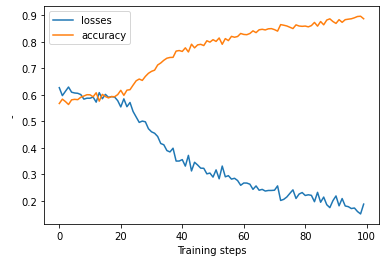

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label="losses")
plt.plot(train_acc, label="accuracy")
plt.xlabel("Training steps")
plt.ylabel("-")
plt.legend()
plt.show()